In [84]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.preprocessing import MinMaxScaler

# Read, Convert

In [85]:
src_folder_path = ".\\data"
df = pd.concat([
    #pd.read_csv(src_folder_path + "\\20220421-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "\\20220425-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";")
], ignore_index=True)

In [86]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

def array_from_string(x):
    if isinstance(x, str):
        x = x[1:] # remove first char "["
        x = x[:-1] # remove last char "]"
        return np.fromstring(x, sep=",")
    else:
        return x

# convert arrays
for curFeature in arrayFeatures:
    df[curFeature] = df[curFeature].apply(array_from_string)

In [87]:
STAYING = 10
JUMP_LEFT = 11
JUMP_RIGHT = 12
OTHER = 20
FAKE_JUMP_LEFT = 30
FAKE_JUMP_RIGHT = 31

LABEL_COL = 'activity-code'

def encode_label(value):
    if value == 'staying': return STAYING
    if value == 'jump_left': return JUMP_LEFT
    if value == 'jump_right': return JUMP_RIGHT
    if value == 'other': return OTHER
    if value == 'fake_jump_left': return FAKE_JUMP_LEFT
    if value == 'fake_jump_right': return FAKE_JUMP_RIGHT

# convert label
df[LABEL_COL] = df['activity'].apply(encode_label)

In [88]:
def get_activity_class(activityCode):
    if activityCode == JUMP_LEFT or activityCode == JUMP_RIGHT:
        return 'lateral-move'
    if activityCode == FAKE_JUMP_LEFT or activityCode== FAKE_JUMP_RIGHT:
        return 'fake-move'
    else:
        return 'staying'
    
# convert label
df['activity-class'] = df[LABEL_COL].apply(get_activity_class)

# Explore

In [89]:
print(f'Rows: {df.shape[0]} | Cols: {df.shape[1]}')
df.columns

Rows: 64 | Cols: 63


Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [90]:
df.head(3)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id,activity-code,activity-class
0,2022-04-25T13:36:29.355Z,2022-04-25T13:36:30.651Z,2,"[-0.3131873, -0.3131873, -0.3131873, 0.2938868...","[0.19586897, -0.3540504, -0.3540504, -0.354050...","[-0.046258926, 0.9705639, 0.9705639, 0.0256557...",-0.313187,-0.175891,0.293887,0.019172,...,0.010471,-0.024077,-0.003113,0.011636,0.000080,0.008957,staying,a5ad2ede1017aadb3dd3df128cd0b0b5,10,staying
1,2022-04-25T13:36:37.526Z,2022-04-25T13:36:38.820Z,2,"[-0.18463248, -0.18463248, -0.18463248, -0.184...","[-0.14506292, -0.14506292, -0.14506292, -0.145...","[0.21424389, 0.21424389, 0.21424389, 0.2142438...",-2.175002,-0.176033,1.436902,0.332481,...,0.053843,-0.063549,0.029638,0.409440,0.004947,0.070335,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11,lateral-move
2,2022-04-25T13:36:40.351Z,2022-04-25T13:36:41.634Z,2,"[-0.13953477, -0.13953477, -0.13953477, -0.139...","[0.67429686, 0.67429686, 0.67429686, 0.6742968...","[-0.33638382, -0.33638382, 0.35348988, 0.35348...",-0.139535,-0.057040,0.463732,0.028520,...,0.033225,-0.073355,-0.021567,0.026335,0.000757,0.027509,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11,lateral-move


In [91]:
arraySizes = df['acc-x-m/s^2'].apply(lambda array: len(array))
arraySizes = list(set(arraySizes))
print("Raw array sizes: " + str(arraySizes))

Raw array sizes: [64]


In [92]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 2))

    for curPlt in dataArray:
        plt.subplot(pltIndex)
        plt.plot(curPlt['data'])
        plt.ylabel(curPlt['name'])
        plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

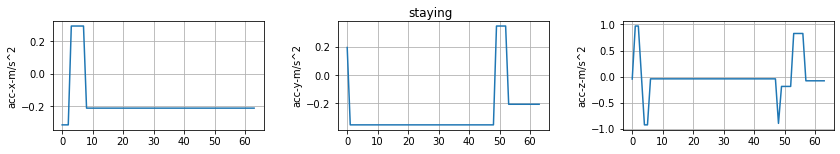

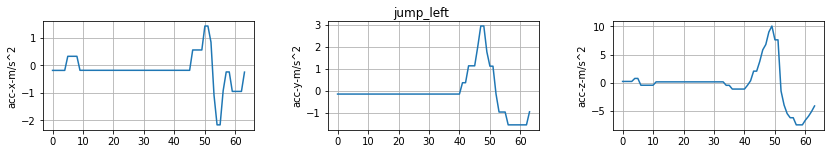

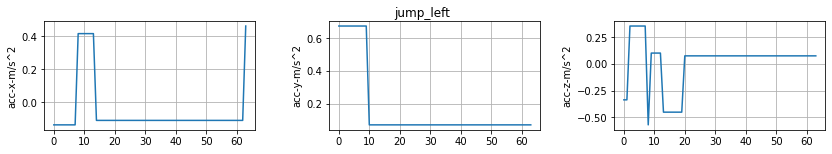

In [93]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')

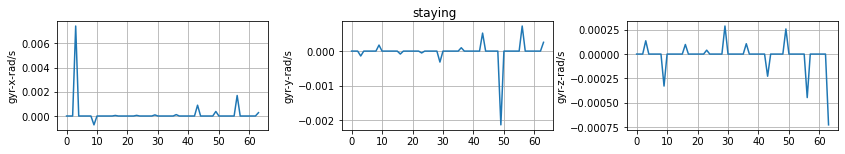

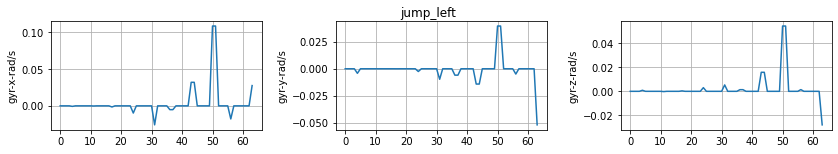

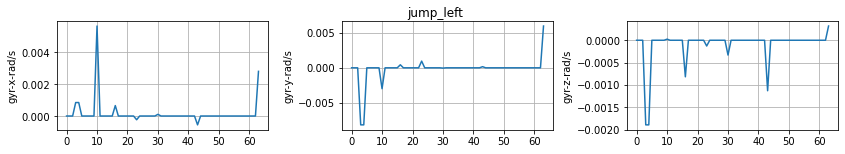

In [94]:
plot_data_from_row(df, 0, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 1, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 2, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')

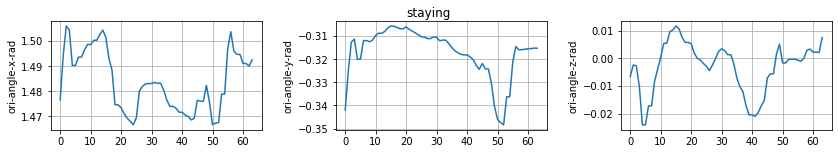

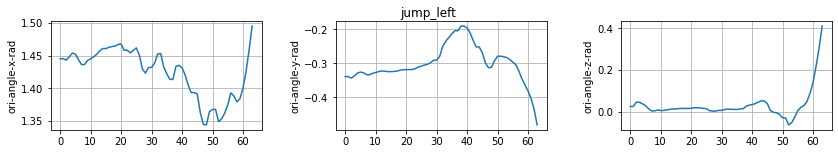

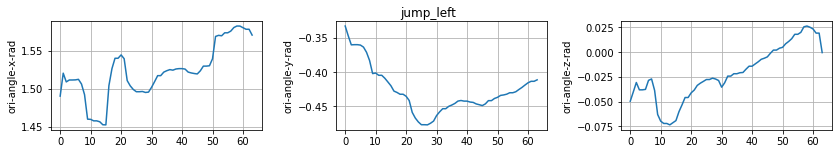

In [95]:
plot_data_from_row(df, 0, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 1, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 2, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')

# Clean

In [96]:
# remove date cols
df.drop('startDate', inplace=True, axis=1)
df.drop('endDate', inplace=True, axis=1)

# remove sensor accuracy cols
df.drop('acc-accuracy', inplace=True, axis=1)
df.drop('gyr-accuracy', inplace=True, axis=1)
df.drop('mag-accuracy', inplace=True, axis=1)

# remove device-id col
df.drop('device-id', inplace=True, axis=1)

# Enrichment

In [97]:
# signal vector magnitude = sqrt(x^2 + y^2 + z^2)
def svmag(xArray, yArray, zArray):
    svmag_array = np.square([xArray, yArray, zArray])
    svmag_array = np.sum(svmag_array, axis=0)
    svmag_array = np.sqrt(svmag_array)
    return svmag_array

# signal magnitude area = sum(abs(x) + abs(y) + abs(z)) / arraySize
def sma(xArray, yArray, zArray):
    arraySize = len(xArray)
    result = np.abs([xArray, yArray, zArray])
    result = np.sum(result)
    return result / arraySize

# pearson correlation coefficient = cov(A, B) / (std(A) * std(B))
def pcorr(arrayA, arrayB):
    corr_matrix = np.corrcoef(arrayA, arrayB)
    corr = corr_matrix[0][1]
    
    if np.isnan(corr):
        return 0
    else:
        return corr
    
# difference between max and min positions
def min_max_diff(array):
    maxIndex = np.argmax(array, axis=0)
    minIndex = np.argmin(array, axis=0)
    return maxIndex - minIndex

# amplitude range = max - min
def amprange(array):
    return np.max(array) - np.min(array)

# average of array quarter
def mean_of_quarter(array, fromIndex, toIndex):
    array = array[fromIndex:toIndex]
    return np.mean(array)

# average peak-trough distance
def aptd(array):
    peakValue = array[0]
    troughValue = array[0]
    prevSlope = 0
    curSlope = 0
    sum = 0
    arraySize = len(array)
    evaluateSize = arraySize + 1
    
    for i in range(evaluateSize):
        if i == 0:
            curValue = array[i]
            continue
        
        prevValue = curValue
        prevSlope = curSlope
        
        if i < arraySize:
            curValue = array[i]
            curSlope = curValue - prevValue
        else:
            curSlope = prevSlope * -1
        
        # peak found
        if prevSlope > 0 and curSlope <= 0:
            peakValue = prevValue
            sum += peakValue - troughValue
            #print(f'=== peak found ({troughValue} to {peakValue})')
        # trough found
        elif prevSlope < 0 and curSlope >= 0:
            troughValue = prevValue
            sum += troughValue - peakValue
            #print(f'=== trough found ({peakValue} to {troughValue})')
            
    return sum / arraySize

def median_absolute_deviation(array):
    return np.median(np.absolute(array - np.median(array)))

In [98]:
newFeatures = [
    # accelerometer
    {
        'name': 'acc-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-y-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-min-max-diff', 'dtype': np.float64,
        'func': (lambda row: min_max_diff(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-amprange', 'dtype': np.float64,
        'func': (lambda row: amprange(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-mean-1quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 0, 16))
    },
    {
        'name': 'acc-x-mean-2quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 16, 32))
    },
    {
        'name': 'acc-x-mean-3quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 48))
    },
    {
        'name': 'acc-x-mean-4quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 64))
    },
    {
        'name': 'acc-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-z-m/s^2"]))
    },
    # gyroscope
    {
        'name': 'gyr-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-y-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-z-rad/s"]))
    },
    # magnetometer
    {
        'name': 'mag-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-y-rad"]))
    },
    { 
        'name': 'mag-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    # activity label
    {
        'name': 'lateral-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT or row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'fake-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == FAKE_JUMP_LEFT or row[LABEL_COL] == FAKE_JUMP_RIGHT)
    },
    {
        'name': 'jump-left', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT)
    },
    {
        'name': 'jump-right', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'staying', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] != JUMP_LEFT and row[LABEL_COL] != JUMP_RIGHT)
    }
    
    #TODO: add the folllowing
    #FFT coef https://docs.scipy.org/doc/scipy/tutorial/fft.html
    #entropy https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
    #kurtosis, energy, normalized energy
]

print("added new features")

# add new features
for newFeature in newFeatures:
    # add new column
    df[newFeature['name']] = pd.Series(df[LABEL_COL].apply(lambda x: 0), dtype=newFeature['dtype'])

    # fill new column
    for rowIndex, row in df.iterrows():
        df.at[rowIndex, newFeature['name']] = newFeature['func'](row);
        
        if (rowIndex == 0):
            print(newFeature['name'] + ": " + str(df.at[rowIndex, newFeature['name']]))

added new features
acc-svmag: [0.37227789 1.07955188 1.07955188 0.46084637 1.03341582 1.03341582
 0.46212245 0.46212245 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277 0.41411277
 0.98699214 0.44857922 0.44857922 0.44857922 0.44857922 0.87868148
 0.87868148 0.87868148 0.87868148 0.30631319 0.30631319 0.30631319
 0.30631319 0.30631319 0.30631319 0.30631319]
acc-sma: 0.7226218852499999
acc-pcorr-xy: -0.1413981382530532
acc-pcorr-xz: -0.37717519669197
acc-pcorr-yz: -0.02576257133096122
acc-x-min-max-diff: 3.0

C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



acc-x-amprange: 0.6070741399999999
acc-x-mean-1quarter: -0.07212282125000001
acc-x-mean-2quarter: -0.21047968
acc-x-mean-3quarter: -0.21047968
acc-x-mean-4quarter: -0.21047968
acc-x-aptd: 0.0016048065624999983
acc-y-aptd: -0.006303928750000002
acc-z-aptd: 0.010547668062500001
acc-x-mad: 0.0
acc-y-mad: 0.0
acc-z-mad: 0.0
gyr-svmag: [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.43771875e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.20909438e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38250960e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.54720122e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.38889181e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.84124996e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05957373

# Describe

In [99]:
df.describe()

,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,acc-y-std,...,gyr-x-aptd,gyr-y-aptd,gyr-z-aptd,gyr-x-mad,gyr-y-mad,gyr-z-mad,mag-sma,mag-pcorr-xy,mag-pcorr-xz,mag-pcorr-yz
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,6.400000e+01,64.000000,64.0,64.0,64.0,64.000000,64.000000,64.000000,64.000000
mean,-1.087310,0.031863,1.017223,0.281247,0.420416,-1.167940,0.011713,1.550362,0.948792,0.582298,...,0.001034,-2.594056e-04,0.000171,0.0,0.0,0.0,2.711922,0.341840,0.412997,-0.083985
std,1.038483,0.105624,0.880460,0.351200,0.325815,1.641858,0.133362,2.084783,2.031570,0.787019,...,0.005736,1.021038e-03,0.001498,0.0,0.0,0.0,0.656657,0.474651,0.503029,0.521952
min,-4.213076,-0.225223,-0.048962,0.000000,0.000000,-6.457731,-0.280774,-0.158317,0.000000,0.000000,...,-0.001858,-3.993995e-03,-0.002475,0.0,0.0,0.0,1.763421,-0.985806,-0.976974,-0.954200
25%,-1.847042,-0.031350,0.397320,0.020206,0.142148,-1.632527,-0.085150,0.142227,0.000723,0.026665,...,-0.000079,-1.845119e-04,-0.000058,0.0,0.0,0.0,2.191329,0.093267,0.108205,-0.423167
50%,-0.698869,0.032352,0.612086,0.096239,0.310111,-0.363228,0.007087,0.357444,0.037144,0.192696,...,0.000003,-1.106767e-07,0.000002,0.0,0.0,0.0,2.473889,0.432763,0.571537,-0.222126
75%,-0.446052,0.087639,1.443451,0.423660,0.650868,-0.021162,0.126930,2.983706,1.039215,1.019021,...,0.000204,9.257414e-05,0.000056,0.0,0.0,0.0,3.339486,0.693767,0.856796,0.220891
max,0.246406,0.264318,3.066123,1.077886,1.038213,0.179110,0.285827,7.229198,10.683207,3.268517,...,0.032706,2.669039e-03,0.008118,0.0,0.0,0.0,4.410092,0.991732,0.995562,0.979660


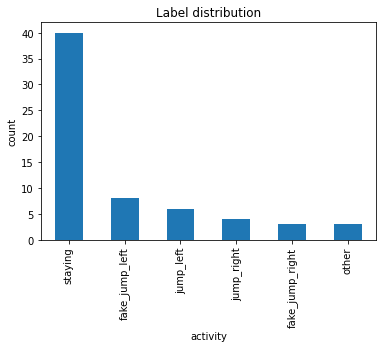

In [100]:
df['activity'].value_counts().plot.bar(title='Label distribution')
plt.ylabel('count')
plt.xlabel('activity')
plt.show()

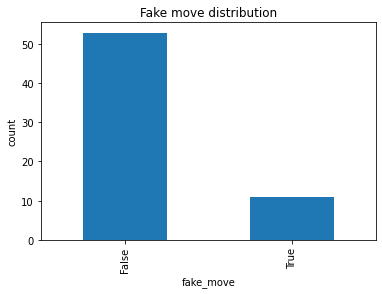

In [101]:
df['fake-move'].value_counts().plot.bar(title='Fake move distribution')
plt.ylabel('count')
plt.xlabel('fake_move')
plt.show()

In [102]:
MIN_NEG_CORR = -0.5
MIN_POS_CORR = 0.5

In [103]:
# remove original array features
for curFeature in arrayFeatures:
    df.drop(curFeature, inplace=True, axis=1)

# remove extracted array features
df.drop('acc-svmag', inplace=True, axis=1)
df.drop('gyr-svmag', inplace=True, axis=1)
df.drop('mag-svmag', inplace=True, axis=1)

In [104]:
# apply feature scaling
scaled_df = df.copy()
scaled_df.drop('activity', inplace=True, axis=1)
scaled_df.drop('activity-class', inplace=True, axis=1)

col_names = scaled_df.columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df))
scaled_df.columns = col_names

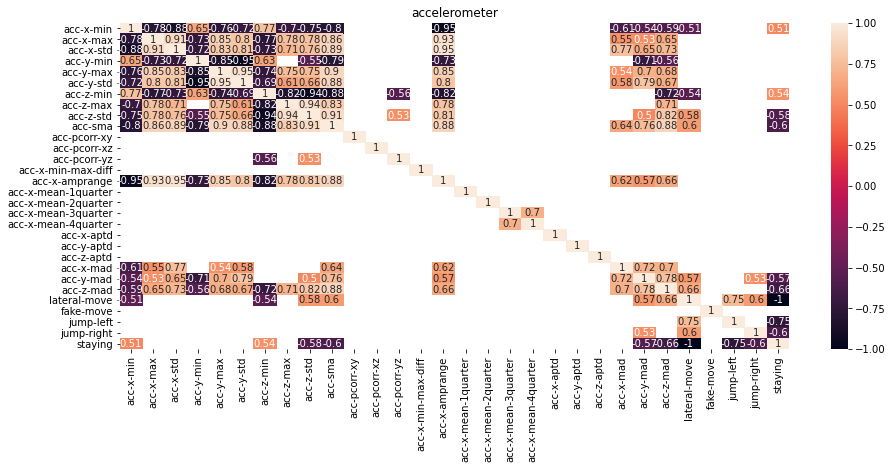

In [105]:
dfCorr = scaled_df[[
    'acc-x-min',
    #'acc-x-mean',
    'acc-x-max',
    #'acc-x-var',
    'acc-x-std',
    'acc-y-min',
    #'acc-y-mean',
    'acc-y-max',
    #'acc-y-var',
    'acc-y-std',
    'acc-z-min',
    #'acc-z-mean',
    'acc-z-max',
    #'acc-z-var',
    'acc-z-std',
    'acc-sma',
    'acc-pcorr-xy',
    'acc-pcorr-xz',
    'acc-pcorr-yz',
    'acc-x-min-max-diff',
    'acc-x-amprange',
    'acc-x-mean-1quarter',
    'acc-x-mean-2quarter',
    'acc-x-mean-3quarter',
    'acc-x-mean-4quarter',
    'acc-x-aptd',
    'acc-y-aptd',
    'acc-z-aptd',
    'acc-x-mad',
    'acc-y-mad',
    'acc-z-mad',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('accelerometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

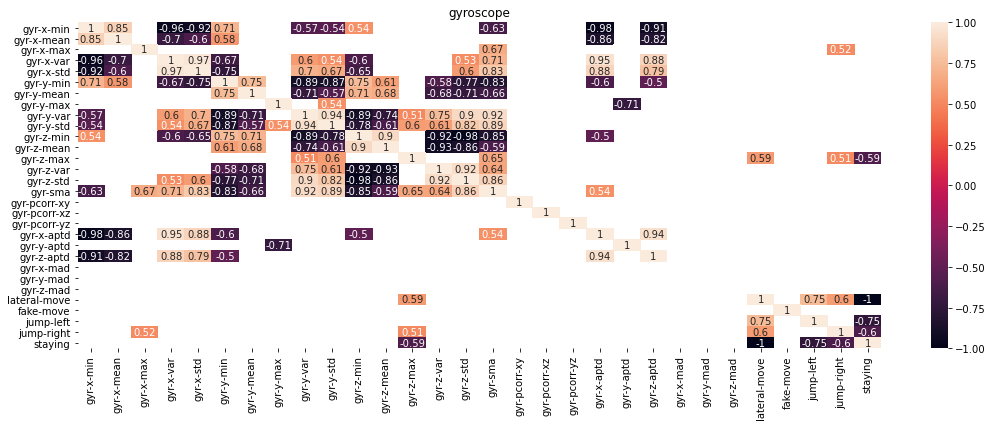

In [106]:
dfCorr = scaled_df[[
    'gyr-x-min',
    'gyr-x-mean',
    'gyr-x-max',
    'gyr-x-var',
    'gyr-x-std',
    'gyr-y-min',
    'gyr-y-mean',
    'gyr-y-max',
    'gyr-y-var',
    'gyr-y-std',
    'gyr-z-min',
    'gyr-z-mean',
    'gyr-z-max',
    'gyr-z-var',
    'gyr-z-std',
    'gyr-sma',
    'gyr-pcorr-xy',
    'gyr-pcorr-xz',
    'gyr-pcorr-yz',
    'gyr-x-aptd',
    'gyr-y-aptd',
    'gyr-z-aptd',
    'gyr-x-mad',
    'gyr-y-mad',
    'gyr-z-mad',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,6))
plt.title('gyroscope')
sn.heatmap(dfCorr, annot=True)
plt.show()

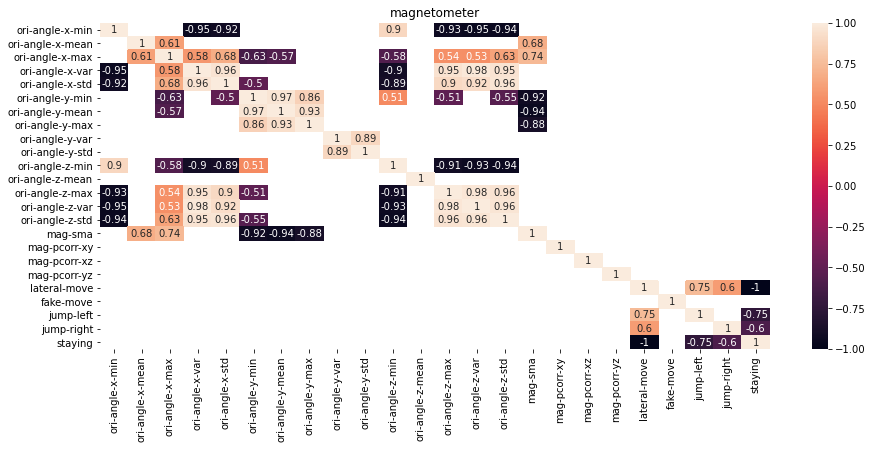

In [107]:
dfCorr = scaled_df[[
    'ori-angle-x-min',
    'ori-angle-x-mean',
    'ori-angle-x-max',
    'ori-angle-x-var',
    'ori-angle-x-std',
    'ori-angle-y-min',
    'ori-angle-y-mean',
    'ori-angle-y-max',
    'ori-angle-y-var',
    'ori-angle-y-std',
    'ori-angle-z-min',
    'ori-angle-z-mean',
    'ori-angle-z-max',
    'ori-angle-z-var',
    'ori-angle-z-std',
    'mag-sma',
    'mag-pcorr-xy',
    'mag-pcorr-xz',
    'mag-pcorr-yz',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('magnetometer')
sn.heatmap(dfCorr, annot=True)
plt.show()